In [ ]:
#All dependencies
!pip install langchain transformers ctransformers ctransformers[cuda]
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir --verbose
# !pip install llama-cpp-python
# !wget -O llama-2-7b-chat.Q4_0.gguf "https://huggingface.co/TheBloke/Llama-2-7b-Chat-GGUF/resolve/main/llama-2-7b-chat.Q4_0.gguf"
!wget -O llama-2-13b-chat.Q4_0.gguf "https://huggingface.co/TheBloke/Llama-2-13B-chat-GGUF/resolve/main/llama-2-13b-chat.Q4_0.gguf"
!pip install pypdf chromadb huggingface_hub
!pip install python-pptx yfinance python-docx pymongo
!pip install plotly -U kaleido yfinance requests beautifulsoup4 mpld3 markdown2 tabulate
!pip install -U deep-translator
!apt-get update
!apt-get install -y libnss3 libnspr4 libatk1.0-0 libatk-bridge2.0-0 libcups2 libxkbcommon0 libatspi2.0-0 libxcomposite1 libxdamage1 libxrandr2 libgbm1 libpango-1.0-0 libcairo2 libasound2
!pip install playwright duckduckgo_search
!pip install wikipedia-api
!python3 -m pip install googlesearch-python
!pip install nest-asyncio playwright
import nest_asyncio
nest_asyncio.apply()
!playwright install


Streaming output truncated to the last 5000 lines.
        |   ^ ~~
  /tmp/pip-install-ddjqkiec/llama-cpp-python_e5957df78b784a87b1d09f14bd47d339/vendor/llama.cpp/ggml-cuda.cu:5756:3: warning: style of line directive is a GCC extension
   5756 | }
        |   ^
  /tmp/pip-install-ddjqkiec/llama-cpp-python_e5957df78b784a87b1d09f14bd47d339/vendor/llama.cpp/ggml-cuda.cu:5757:3: warning: style of line directive is a GCC extension
   5757 |
        |   ^
  /tmp/pip-install-ddjqkiec/llama-cpp-python_e5957df78b784a87b1d09f14bd47d339/vendor/llama.cpp/ggml-cuda.cu:5759:3: warning: style of line directive is a GCC extension
   5759 |     const ggml_tensor * src0, const ggml_tensor * src1, ggml_tensor * dst,
        |   ^ ~~
  /tmp/pip-install-ddjqkiec/llama-cpp-python_e5957df78b784a87b1d09f14bd47d339/vendor/llama.cpp/ggml-cuda.cu:5760:3: warning: style of line directive is a GCC extension
   5760 |     const float * src0_dd, const float * src1_dd, float * dst_dd, const cudaStream_t & main_stream

In [ ]:
import wikipediaapi
from googlesearch import search
from langchain.document_loaders import AsyncChromiumLoader
from langchain.document_transformers import BeautifulSoupTransformer
import asyncio
from langchain.document_loaders import AsyncChromiumLoader
from langchain.document_transformers import BeautifulSoupTransformer

def analysis(user_input):
    try:


        web_info=''
        web_links=[]

        from duckduckgo_search import DDGS
        with DDGS() as ddgs:
            results = [r for r in ddgs.text(user_input, max_results=3)]
            for i in results:
              web_links.append(i["href"])

        from langchain.document_loaders import AsyncChromiumLoader
        from langchain.document_transformers import BeautifulSoupTransformer
        print(web_links)
        content=''
        # Load HTML
        for i in web_links:
            try:
              loader = AsyncChromiumLoader([i])
              html = loader.load()

              # Transform
              bs_transformer = BeautifulSoupTransformer()
              docs_transformed = bs_transformer.transform_documents(html,tags_to_extract=["p","h3","a","div","h2","h1","h4","li","ul","table"])

              # Result
              content+=docs_transformed[0].page_content[0:2000]
            except Exception as e:
              continue
        print(content)
        # print(content)

        template="""
        [INST] <<SYS>>
        Based on the give news content, predict a sentimental score of the stock which can be between 0 to 1, where 0 is negative, 0.5 is neutral
        and 1 is positive
        <</SYS>>
        {content}
        [/INST]
        """
        prompt = PromptTemplate(template=template, input_variables=["content"])
        llm_chain = LLMChain(prompt=prompt, llm=lg('',30,750,250,'/content/llama-2-13b-chat.Q4_0.gguf'))
        #JSONDecodeError
        response = llm_chain.run(content=content)
        import gc
        gc.collect()
        senti_score=response
        # print(web_summary)

        print(senti_score)
        return [senti_score,web_links]
    except Exception as e:
        return ['','']

In [ ]:

from langchain.llms import LlamaCpp
from langchain import PromptTemplate, LLMChain
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

def lg(grammar_file,max_new_tokens,n_ctx,n_batch,model_path):

  # Callbacks support token-wise streaming
  callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

  n_gpu_layers = 30  # Change this value based on your model and your GPU VRAM pool.
  n_batch = n_batch  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.


  #Default length 4096, implement sub concurrency+
  llm_grammar = LlamaCpp(
        model_path=model_path,
        n_gpu_layers=n_gpu_layers,
        n_batch=n_batch,
        callback_manager=callback_manager,
        max_tokens=max_new_tokens,   #250,500,4096
        n_ctx=n_ctx,
        # tempreature=tempreature,
        verbose=True,  # Verbose is required to pass to the callback manager
        grammar_path= grammar_file,
  )

  return llm_grammar

In [ ]:
import yfinance as yf
import plotly.graph_objects as go
from plotly.io import to_image
import base64
def fetch_stock_price(symbol,start,end):
  try:
      data = yf.download(symbol, start=start, end=end)
      print(data)
      return data
  except Exception as e:
      #print(f"Error fetching stock data for {symbol}: {str(e)}")
      return None

In [ ]:

def stock_chat(user_input):
  print("USER : ", user_input)
  print("Classification : ")
  template="""
    [INST] <<SYS>>

  Based on the user query, give the name, symbol of the stock and the date range for showing the price in YYYY-MM-DD format and Chart Type (Line Chart, Bar Graph, Pie Chart or Candle Sticks Chart).
  Today's date is 2023-10-30.
    <</SYS>>
    USER: {user_input}
    [/INST]
  """

  prompt = PromptTemplate(template=template, input_variables=["user_input"])
  llm_chain = LLMChain(prompt=prompt, llm=lg("/content/t_stock_analysis.gbnf",300,750,250,'/content/llama-2-13b-chat.Q4_0.gguf'))
  #JSONDecodeError
  response = llm_chain.run(user_input=user_input)
  res=response
  # print(res)
  import re
  import json

  import gc
  print("\n")
  web_result=analysis(user_input)
  sentimental_score=web_result[0]
  web_reference=web_result[1]
  gc.collect()
  # Your mixed string
  mixed_string = "This is some text before the JSON data {'key': 'value'} and more text after."

  # Use regular expressions to find JSON data within the string
  json_match = re.search(r'\{.*\}', mixed_string)

  if json_match:
      json_str = json_match.group()
      try:
          # Parse the extracted JSON string
          json_data = json.loads(json_str)
          print("Extracted JSON data:", json_data)
      except json.JSONDecodeError as e:
          print(f"Error parsing JSON: {e}")
  else:
      print("No JSON data found in the string.")

  stock_data = fetch_stock_price(json_data['stock_symbol'],json_data['start_date'],json_data['end_date'])
  print(stock_data)
  response=''
  chart_type=''
  stock_name=json_data['stock_name']
  stock_symbol=json_data['stock_symbol']
  chart_close=''
  chart_open=''
  chart_high=''
  chart_low=''
  chart_date=stock_data.index
  data=stock_data
  # Create a candlestick chart
  fig = go.Figure(data=[go.Candlestick(x=data.index,
                  open=data['Open'],
                  high=data['High'],
                  low=data['Low'],
                  close=data['Close'])])

  # Set chart layout
  fig.update_layout(title=f"{json_data['stock_symbol']} Candlestick Chart",
                    xaxis_title='Date',
                    yaxis_title='Stock Price',
                    xaxis_rangeslider_visible=False)

  # Display the chart in the Jupyter Notebook
  fig.show()
  image_bytes = to_image(fig, format='png')
  image_base64 = base64.b64encode(image_bytes).decode('utf-8')
  # info=search_wiki(user_query)
  chart_open=data['Open']
  chart_high=data['High']
  chart_low=data['Low']
  chart_close=data['Close']
  chart_type='Line Chart'
  chart_date=data.index
  chart_close=data['Close']
  # Display the HTML code for the image
  html_code = f'<img src="data:image/png;base64,{image_base64}" alt="Candlestick Chart">'
  return [html_code, chart_close,stock_symbol,sentimental_score]



In [ ]:
# for i in range(0,5):
#   #Mongob user input

#   result=stock_chat(user_input)

uri = "mongodb+srv://admin:<password>@cluster0.bigdefc.mongodb.net/?retryWrites=true&w=majority"
# Create a new client and connect to the server
client = MongoClient(uri)

In [ ]:
import gc
gc.collect()

In [ ]:
stock_chat("Give me Apple stocks prediction")


import gc
gc.collect()

LSTM

### Stock Market Prediction And Forecasting Using Stacked LSTM

In [ ]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [ ]:
df.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [ ]:
# df1=df.reset_index()['close']
df1=stock_chat[1]

In [ ]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 487ms/step - loss: 0.0206 - val_loss: 0.0505
Epoch 2/100
12/12 [==============================] - 4s 309ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 3/100
12/12 [==============================] - 4s 300ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 4/100
12/12 [==============================] - 3s 287ms/step - loss: 8.1361e-04 - val_loss: 0.0073
Epoch 5/100
12/12 [==============================] - 3s 290ms/step - loss: 6.6860e-04 - val_loss: 0.0062
Epoch 6/100
12/12 [==============================] - 3s 255ms/step - loss: 6.4653e-04 - val_loss: 0.0062
Epoch 7/100
12/12 [==============================] - 3s 291ms/step - loss: 6.6186e-04 - val_loss: 0.0062
Epoch 8/100
12/12 [==============================] - 4s 300ms/step - loss: 6.2498e-04 - val_loss: 0.0049
Epoch 9/100
12/12 [==============================] - 4s 297ms/step - loss: 6.2745e-04 - val_loss: 0.0042
Epoch 10/100
12/12 [==============================] - 4s 303ms/step

12/12 [==============================] - 3s 282ms/step - loss: 1.7841e-04 - val_loss: 0.0014
Epoch 79/100
12/12 [==============================] - 3s 260ms/step - loss: 1.9611e-04 - val_loss: 0.0013
Epoch 80/100
12/12 [==============================] - 3s 281ms/step - loss: 2.0224e-04 - val_loss: 0.0012
Epoch 81/100
12/12 [==============================] - 3s 290ms/step - loss: 2.1049e-04 - val_loss: 0.0020
Epoch 82/100
12/12 [==============================] - 3s 288ms/step - loss: 1.9466e-04 - val_loss: 0.0010
Epoch 83/100
12/12 [==============================] - 3s 284ms/step - loss: 1.5801e-04 - val_loss: 0.0010
Epoch 84/100
12/12 [==============================] - 3s 272ms/step - loss: 1.6260e-04 - val_loss: 9.4397e-04
Epoch 85/100
12/12 [==============================] - 3s 249ms/step - loss: 1.5695e-04 - val_loss: 0.0013
Epoch 86/100
12/12 [==============================] - 3s 242ms/step - loss: 2.0192e-04 - val_loss: 9.7445e-04
Epoch 87/100
12/12 [==============================]

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.1.0'

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

140.9909210035748

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

235.7193088627771

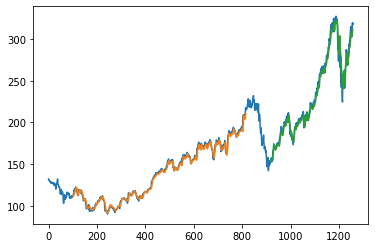

In [ ]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

441

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 100)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.94413203]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.

10 day output [[0.9050924]]
11 day input [0.94950604 0.96424048 0.95512117 0.95989192 0.96635143 0.96246728
 0.92295027 0.9598497  0.98792536 0.98594106 0.92531453 0.92172591
 0.96474711 0.97572406 0.99159841 0.96972895 0.97614625 0.96795575
 1.         0.99016297 0.99050072 0.96538039 0.98488559 0.97086887
 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273
 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725
 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371
 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494
 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402
 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832
 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543
 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148
 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415
 0.92793211 0.948535   0.93333615 0.91746179 0.92544119 0.91771511
 0.9483239  0.9406400

20 day output [[0.90279734]]
21 day input [0.92531453 0.92172591 0.96474711 0.97572406 0.99159841 0.96972895
 0.97614625 0.96795575 1.         0.99016297 0.99050072 0.96538039
 0.98488559 0.97086887 0.94026007 0.87748037 0.83483915 0.85413324
 0.77336823 0.77269273 0.88014017 0.84007431 0.89673225 0.85527316
 0.83884995 0.74233725 0.82327113 0.78143207 0.6665963  0.7921557
 0.64118044 0.68614371 0.66001013 0.65203074 0.58642236 0.56586169
 0.66089673 0.65515494 0.70970193 0.66452757 0.69437642 0.69218104
 0.63569197 0.65266402 0.63780292 0.7267162  0.71388162 0.74191506
 0.75002111 0.77222832 0.83049059 0.8194292  0.8289707  0.8125475
 0.78776492 0.75162543 0.78426074 0.77974331 0.81326522 0.8141096
 0.79473106 0.83336148 0.85898843 0.83901883 0.85628641 0.87486279
 0.88782403 0.90095415 0.92793211 0.948535   0.93333615 0.91746179
 0.92544119 0.91771511 0.9483239  0.94064004 0.96635143 0.9563033
 0.96491598 0.94413203 0.93795931 0.92865342 0.91987926 0.91280973
 0.90777564 0.90473258 0

28 day output [[0.903272]]
29 day input [1.         0.99016297 0.99050072 0.96538039 0.98488559 0.97086887
 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273
 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725
 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371
 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494
 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402
 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832
 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543
 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148
 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415
 0.92793211 0.948535   0.93333615 0.91746179 0.92544119 0.91771511
 0.9483239  0.94064004 0.96635143 0.9563033  0.96491598 0.94413203
 0.93795931 0.92865342 0.91987926 0.91280973 0.90777564 0.90473258
 0.90339231 0.90332204 0.90403908 0.90509242 0.90611798 0.90686554
 0.90720606 0.90711629

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(df1)

1258

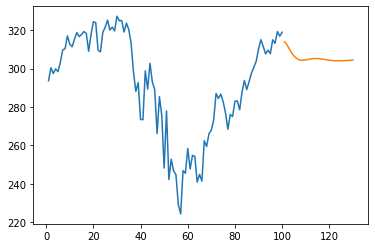

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

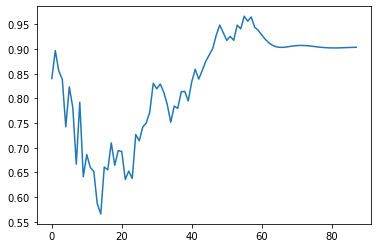

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

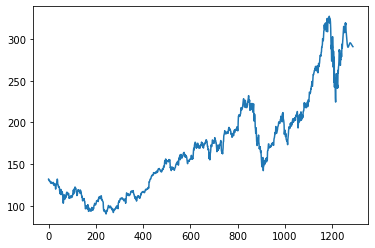

In [ ]:
plt.plot(df3)